<div align='center'><font size='6'>CS304_Project2</font></div>

<div align='center'>Yuchen Song, Yiwei Liang</div>

# 1. Record Audio

In [1]:
import keyboard
import time
import wave
import pyaudio
import numpy as np
import IPython.display as ipd
frames=[]
#Define hit-to-talk function and set 's' as the start key
def hit_to_talk():
    keyboard.wait('s')
    time.sleep(2)
    print("Please talk")

#Define the function to calculate the energy of samples in decibel
def EnergyPerSampleInDecibel(audioframe):
    audioframe=np.frombuffer(np.array(audioframe),np.int16)
    np_audioframe=np.array(audioframe,dtype='int64')
    energy= 10*np.log10(np.sum(np.square(np_audioframe)))
    return energy

#Define the function to calculate the initial backgorund energy 
def find_ini_background(audioframe):
    background_energy=0
    background_energy+=EnergyPerSampleInDecibel(audioframe)
    return background_energy/10

#Define the calssifyFrame function to find the endpointing
def classifyFrame(audioframe,background,level, First_run):
    forgetfactor=2
    isSpeech=False
    current = EnergyPerSampleInDecibel(audioframe)
    if First_run:
        First_run=False
        level=EnergyPerSampleInDecibel(audioframe)
    else:
        level=((level*forgetfactor)+current)/(1+forgetfactor)
    threshold=10
    adjustment=0.05
    print('Background',background,'current',current, 'level', level)
    if current < background:
        background = current
    else:
        background+=(current - background)*adjustment
    if (level < background): level = background
    # print(level-background)
    if (level - background > threshold): isSpeech = True
    return background,level,isSpeech

def record(frames):
    #parameters for recording
    CHUNK = 1600
    resolution = pyaudio.paInt16
    CHANNELS = 1
    sampling_rate = 16000
    stop_record_time=2
    stop_speak_time=0
    stop_speak_per_loop=0.1
    isSpeech=False
    p=pyaudio.PyAudio()
    stream = p.open(format=resolution, channels=CHANNELS, rate=sampling_rate, input=True, frames_per_buffer=CHUNK)
    
    level=0
    First_run=True
    frames_to_store=[]
    inspeech=False
    background=0
    First_inspeech=0
    
    while True:
        #If it is the first run, read the data of 10 chunks to calculate the average energy of these 10 chunks and set it as the initial value of background
        if First_run:
            audioframe=stream.read(CHUNK*10)
            background=find_ini_background(audioframe)
            First_run=False
        #Otherwise, read the data of 1 chunk to calculate energy in the classifyFrame function
        else: 
            audioframe=stream.read(CHUNK)
        #Save the data of each chunk in the list 'frames'
            
            background,level,isSpeech=classifyFrame(audioframe,background,level,First_run)
        # print(isSpeech)
        if isSpeech:
            if First_inspeech==0:
                First_inspeech=1
                frames_to_store=[]
            if frames_to_store!=[] and First_inspeech==1:
                for frame in frames_to_store:
                    frames.append(frame)
                    frames_to_store=[]
            frames.append(audioframe)
            stop_speak_time=0
        #level,isSpeech=classifyFrame(audioframe,background,level,First_run)
        #After the first iteration set First_run as False
        else: 
            if stop_speak_time<stop_record_time:
                frames_to_store.append(audioframe)
            stop_speak_time+=0.1
                
        
        #if the duration for which the energy remains below the threshold is too long, stop recording
        if stop_speak_time>=stop_record_time:
            #Save the speech to a wav file
            wf = wave.open('1.wav', 'wb')
            wf.setnchannels(CHANNELS)
            wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
            wf.setframerate(sampling_rate)
            wf.writeframes(b''.join(frames))
            wf.close()
            print("Audio data saved as 1.wav")
            stream.stop_stream()
            stream.close()
            p.terminate()
            break
    
def start():
    hit_to_talk()
    record(frames)
    

In [2]:
a=start()s

Please talk
Background 6.241311589279075 current 50.398026289942536 level 16.79934209664751
Background 8.449147324312248 current 50.43939643287152 level 28.012693542055512
Background 10.548659779740213 current 51.57891751375901 level 35.86810153262334
Background 12.600172666441154 current 52.02253941875131 level 41.25291416133266
Background 14.571291004056661 current 50.97854011102831 level 44.49478947789788
Background 16.391653459405244 current 51.08669864106499 level 46.69209253228692
Background 18.126405718488233 current 51.78398461587324 level 48.38938989348236
Background 19.809284663357484 current 51.976250995811384 level 49.585010260925365
Background 21.41763297998018 current 90.43232625500991 level 63.20078225895355
Background 24.868367643731666 current 103.83336571060106 level 76.74497674283606
Background 28.816617547075136 current 95.92467578879707 level 83.13820975815639
Background 32.17202045916123 current 86.94461591295648 level 84.40701180975641
Background 34.9106502318509

# 2. Functions for getting Log Mel spectrum and Mel cepstrum

## Get 20ms segments

In [3]:
import matplotlib.pyplot as plt
# Divide signal data into 20ms segements with 10ms interval for every two consecutive ones 
def create_segments(signal,sample_rate,width=10):
    num=int(width*sample_rate/1000)
    # first divide signal into 10ms segments
    ten_ms_segments = [signal[i:i+num] for i in range(0, len(signal), num)]
    twenty_ms_segments =[]
    for j in range(len(ten_ms_segments)):
        if j!=0:
            l1=ten_ms_segments[j-1]
            l2=ten_ms_segments[j]
            l=[0 for i in range(num*2)]
            for k in range(len(l1)):
                l[k]=l1[k]
                l[k+len(l1)]=l2[k]
            twenty_ms_segments.append(l)
    return twenty_ms_segments

## Preemphasizing the segmented signal

In [4]:
# Preemphasize each segement
def Preemphasizing(segment):
    pre=np.zeros(len(segment))
    pre[0]=segment[0]
    for i in range(1,len(segment)):
        pre[i]=segment[i]-0.95*segment[i-1]
    return pre

## Windowing

In [5]:
# Window each preemphasized segement
def windowing(pre):
    pre=pre*np.hamming(len(pre))
    return pre

## Zero-padding

In [6]:
# Zero pad each windowed segement
def zero_padding(windowed):
    #zero padding for FFT
    length=512
    windowed_len=len(windowed)
    padding_len=length-windowed_len
    zeros=np.zeros((padding_len,))
    zero_padded=np.concatenate((windowed,zeros))
    return zero_padded

## FFT

In [7]:
# Calculate the power spectrum of a segement
def FFT(frame):
    length=512
    fft=np.fft.rfft(frame, length)
    magnitude = np.abs(fft)
    power = ((1.0 / length) * ((magnitude) ** 2)) 
    return magnitude

## Mel warping function and its inverse function

In [8]:
# Mel warping function
def warping_function(Hz):
    Mel = 2595 * np.log10(1+Hz/700)
    return Mel
# inverse function
def inverse_warping(Mel):
    Hz = 700*(np.power(10,Mel/2595)-1) 
    return Hz

## Get Mel spectrum and Log Mel spectrum

In [89]:
# calculate mel spectra and log mel spectra
def filterbanks(power,filter_num,minHz=133.33,maxHz=6855.4976,length=512):
    maxMel=warping_function(maxHz)
    minMel=warping_function(minHz)
    #get start and end points of triangle filters in Mel
    pointsInMel=np.linspace(minMel,maxMel,filter_num+2)
    #get start and end points of triangle filters in Hz
    pointsInHz=inverse_warping(pointsInMel)
    #get start and end points of tiangle filters in total 257 points
    ranges=np.floor(length/2*pointsInHz/(maxHz-minHz))
    #normalize the triangle filters according to the lower bound
    ranges=ranges-ranges[0]
    #create filter banks with size(number of filters=40, points in power spectrum=257)
    filter_banks=np.zeros((filter_num,len(power)))
    for i in range(1,filter_num+1): 
        #get the left half of the traingle
        for j in range(int(ranges[i-1]),int(ranges[i])):
            filter_banks[i-1,j]=(j-ranges[i-1])/(ranges[i]-ranges[i-1])
        #get the right half of the traingle
        for j in range(int(ranges[i]),int(ranges[i+1])):
            filter_banks[i-1,j]=(ranges[i+1]-j)/(ranges[i+1]-ranges[i])
    #mel spectrum
    filter_banks=filter_banks.T
    Mel=np.dot(power,filter_banks)
    #log mel spectrum
    Log_Mel=10*np.log(Mel) 
    return Mel,Log_Mel

## Get Mel cepstrum and IDCT spectrum

In [10]:
from scipy.fftpack import dct,idct
# use dct to get the cepstral_coefficients
def mel_cepstrum(log_mel):
    cepstral_coefficients=dct(log_mel,axis=-1, type=2, norm='ortho')
    return cepstral_coefficients[:13]

In [11]:
# get idct
def IDCT(log_mel,num):
    IDCT_coefficients=idct(log_mel,type=2, n=num, norm='ortho')
    return IDCT_coefficients

# 3. Other Support Functions

In [99]:
# get log mel spectrum matrix, mel cpestrum matrix and idct matrix, given segments
def get_matrix(segments,num):
    Mel_cepstrum_matrix=[]
    log_Mel_spectrum_matrix=[]
    IDCT_matrix=[]
    for i in range(len(segments)):
        preemphasized=Preemphasizing(segments[i])
        windowed=windowing(preemphasized)
        zero_padded=zero_padding(windowed)
        power_spectrum=FFT(zero_padded)
        Mel_spectrum, log_Mel_spectrum=filterbanks(power_spectrum,num)
        log_Mel_spectrum_matrix.append(log_Mel_spectrum)
        Mel_cepstrum=mel_cepstrum(log_Mel_spectrum)
        Mel_cepstrum_matrix.append(Mel_cepstrum)
        IDCT_spectrum=IDCT(Mel_cepstrum,num)
        IDCT_matrix.append(IDCT_spectrum)
    return log_Mel_spectrum_matrix,Mel_cepstrum_matrix,IDCT_matrix
#plot the spectrum and cepstrum
def plot_show(log_mel_spectrum_matrix, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
    log_mel_spectrum_matrix=log_mel_spectrum_matrix[:, ::-1]
    log_mel_spectrum_matrix_T=log_mel_spectrum_matrix.T
    cax = ax.matshow(log_mel_spectrum_matrix_T.astype("float32"), interpolation="nearest", aspect="auto", cmap=plt.cm.jet, origin="lower")
    fig.colorbar(cax)
    plt.title(title)
    plt.show()

# 4. Main

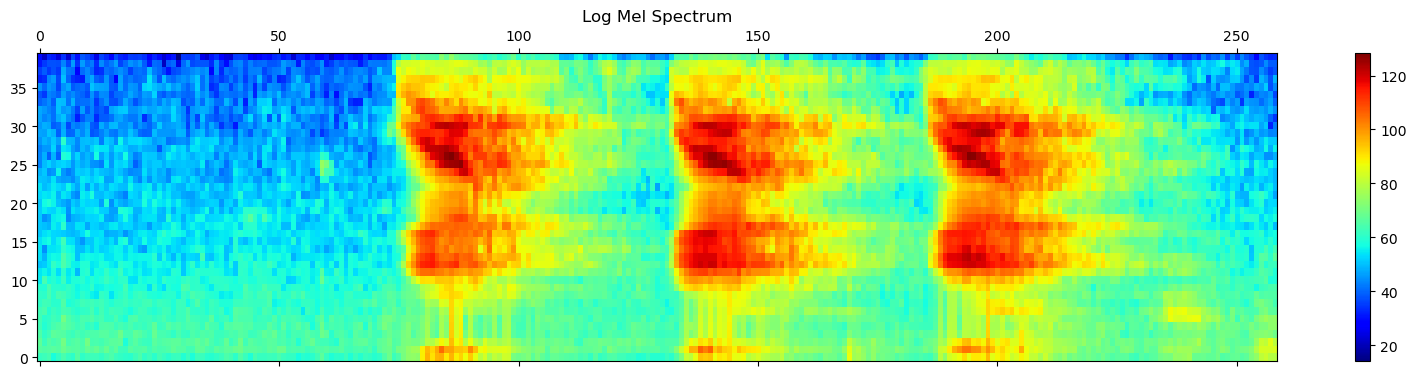

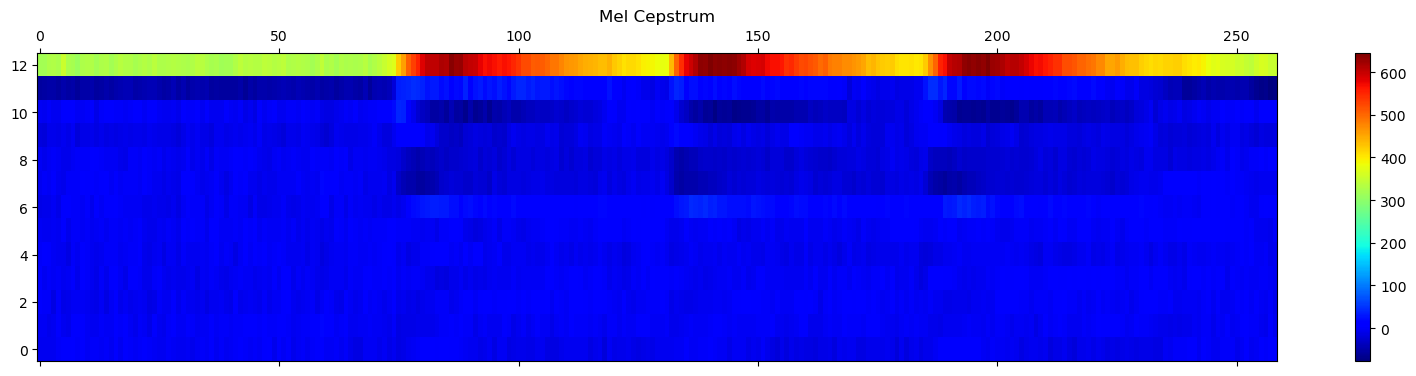

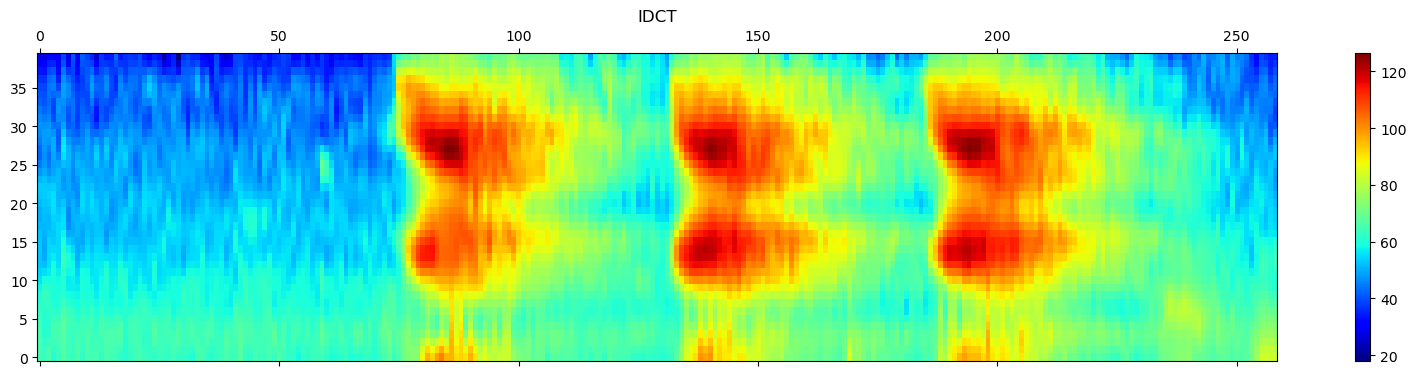

In [100]:
# Load the WAV file
file_path = '1.wav'
wav_file = wave.open(file_path, 'r')

# Get the audio data
frames = wav_file.readframes(-1)
signal = np.frombuffer(frames, dtype=np.int16)

# Get the sample rate and time axis
sample_rate = wav_file.getframerate()
duration = len(signal) / sample_rate
time = np.linspace(0., duration, len(signal))

# Close the WAV file
wav_file.close()

# Get segments from signal
seg=create_segments(signal,sample_rate)

# Get matrix from segments
log_mel_spectrum_matrix,mel_cepstrum_matrix,IDCT_matrix=get_matrix(seg,40)
log_mel_spectrum_matrix,mel_cepstrum_matrix,IDCT_matrix=np.array(log_mel_spectrum_matrix),np.array(mel_cepstrum_matrix),np.array(IDCT_matrix)

# Plot Log Mel spectrum, Mel cepstrum and idct spectrum
plot_show(log_mel_spectrum_matrix,'Log Mel Spectrum')
plot_show(mel_cepstrum_matrix, 'Mel Cepstrum')
plot_show(IDCT_matrix, 'IDCT')


# 5. Modify number of filters to 30 and 25

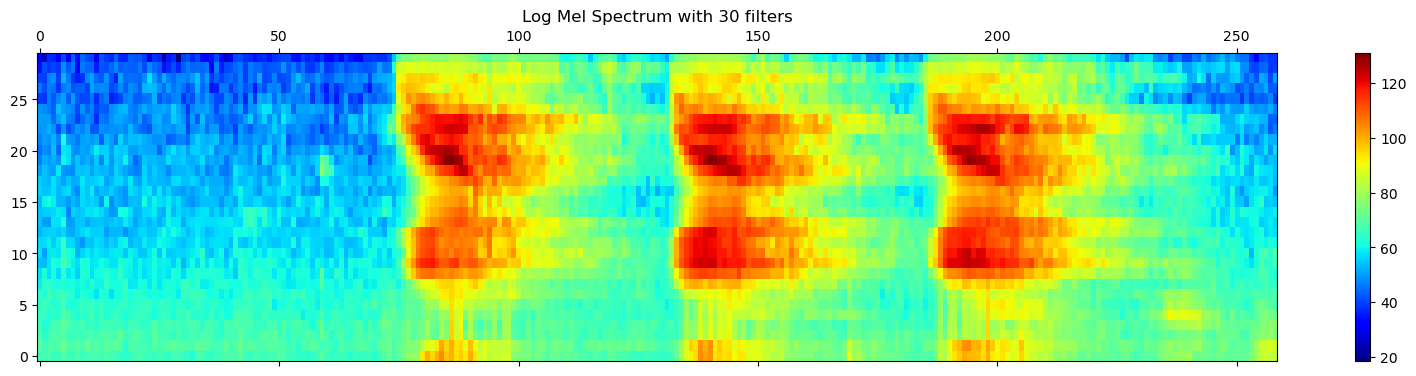

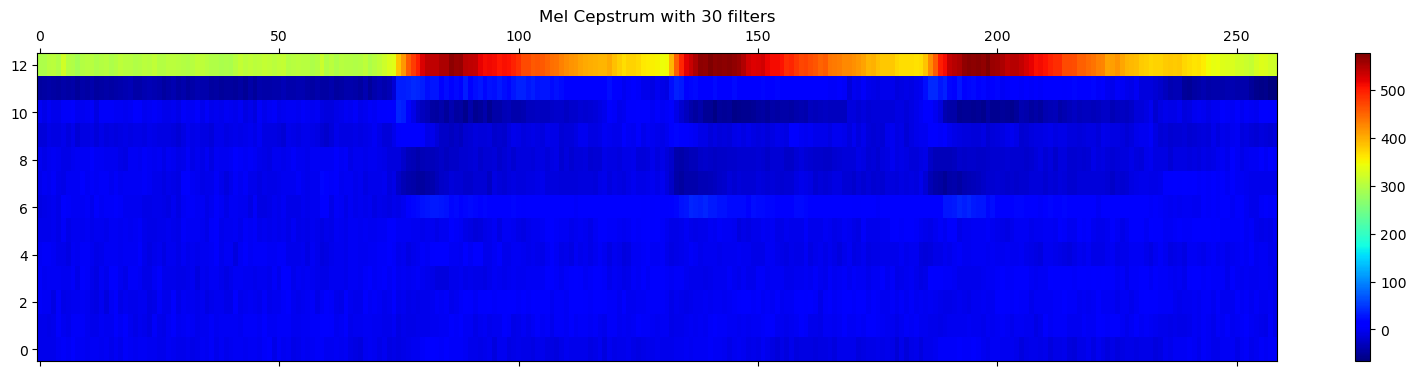

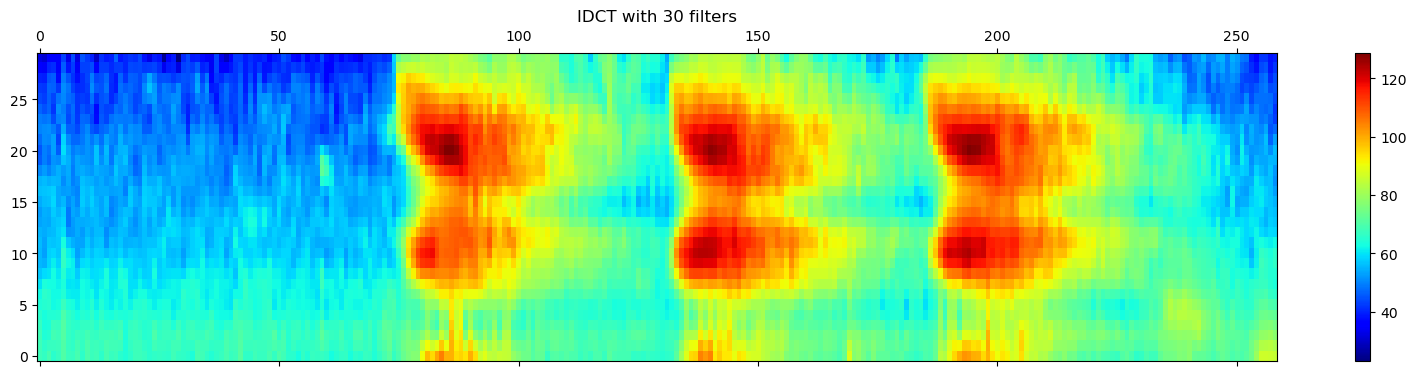

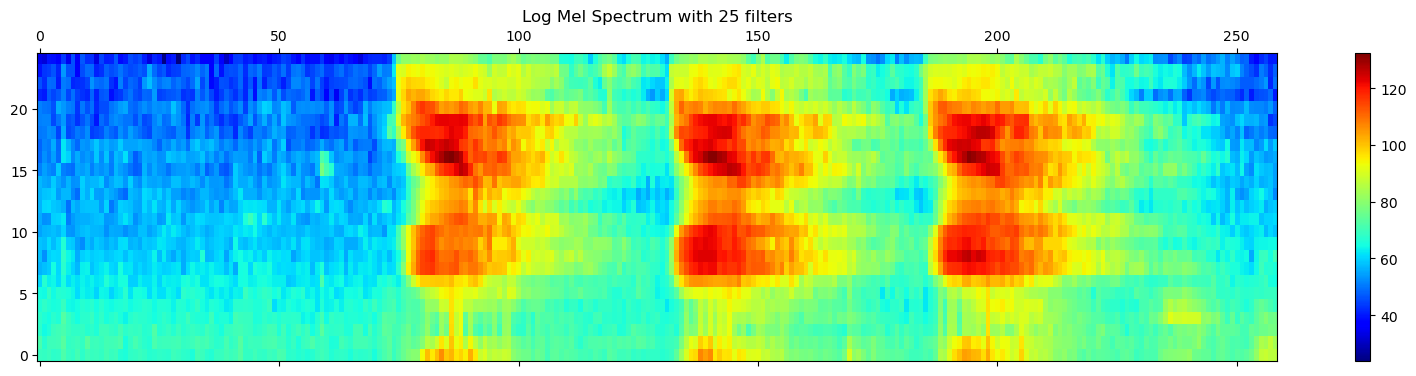

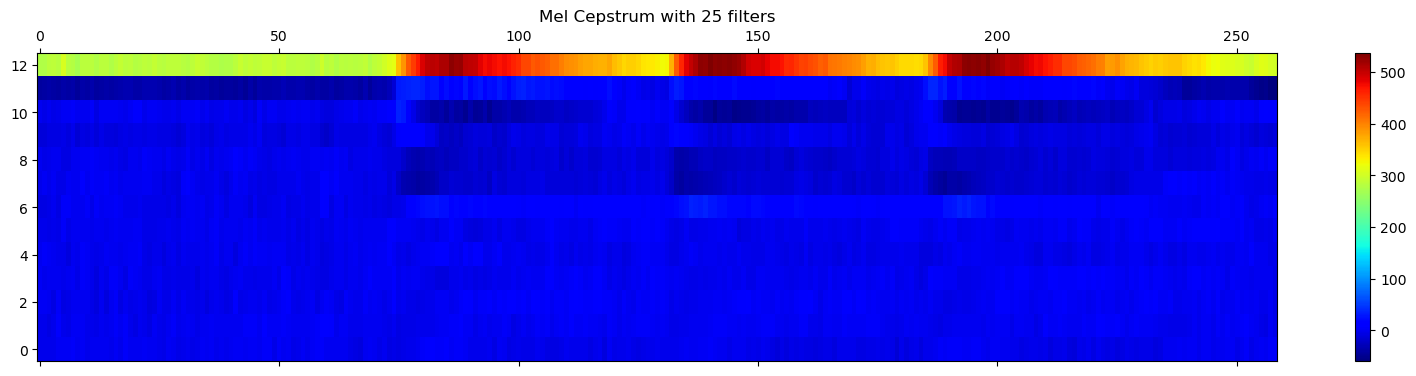

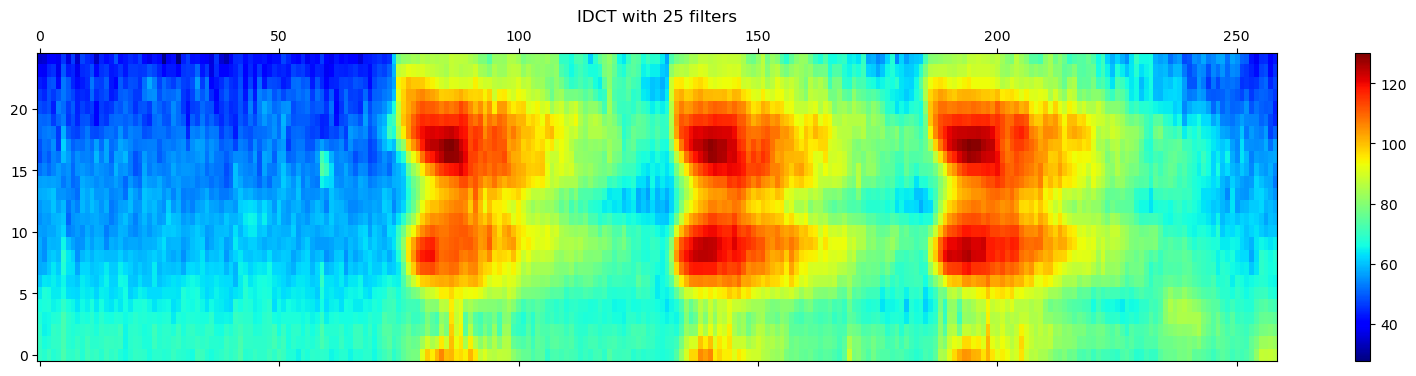

In [101]:
# Get matrix from segments with 30 filters
log_mel_spectrum_matrix1,mel_cepstrum_matrix1,idct_matrix1=get_matrix(seg,30)
log_mel_spectrum_matrix1,mel_cepstrum_matrix1,idct_matrix1=np.array(log_mel_spectrum_matrix1),np.array(mel_cepstrum_matrix1),np.array(idct_matrix1)

# Plot Log Mel spectrum, Mel cepstrum and idct spectrum
plot_show(log_mel_spectrum_matrix1,'Log Mel Spectrum with 30 filters')
plot_show(mel_cepstrum_matrix1, 'Mel Cepstrum with 30 filters')
plot_show(idct_matrix1, 'IDCT with 30 filters')

# Get matrix from segments with 25 filters
log_mel_spectrum_matrix2,mel_cepstrum_matrix2,idct_matrix2=get_matrix(seg,25)
log_mel_spectrum_matrix2,mel_cepstrum_matrix2,idct_matrix2=np.array(log_mel_spectrum_matrix2),np.array(mel_cepstrum_matrix2),np.array(idct_matrix2)

# Plot Log Mel spectrum, Mel cepstrum and idct spectrum
plot_show(log_mel_spectrum_matrix2,'Log Mel Spectrum with 25 filters')
plot_show(mel_cepstrum_matrix2, 'Mel Cepstrum with 25 filters')
plot_show(idct_matrix2, 'IDCT with 25 filters')

# 6. An example segment

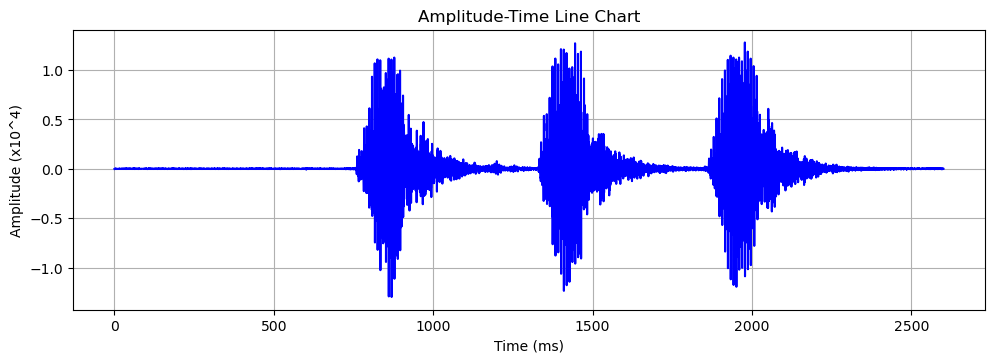

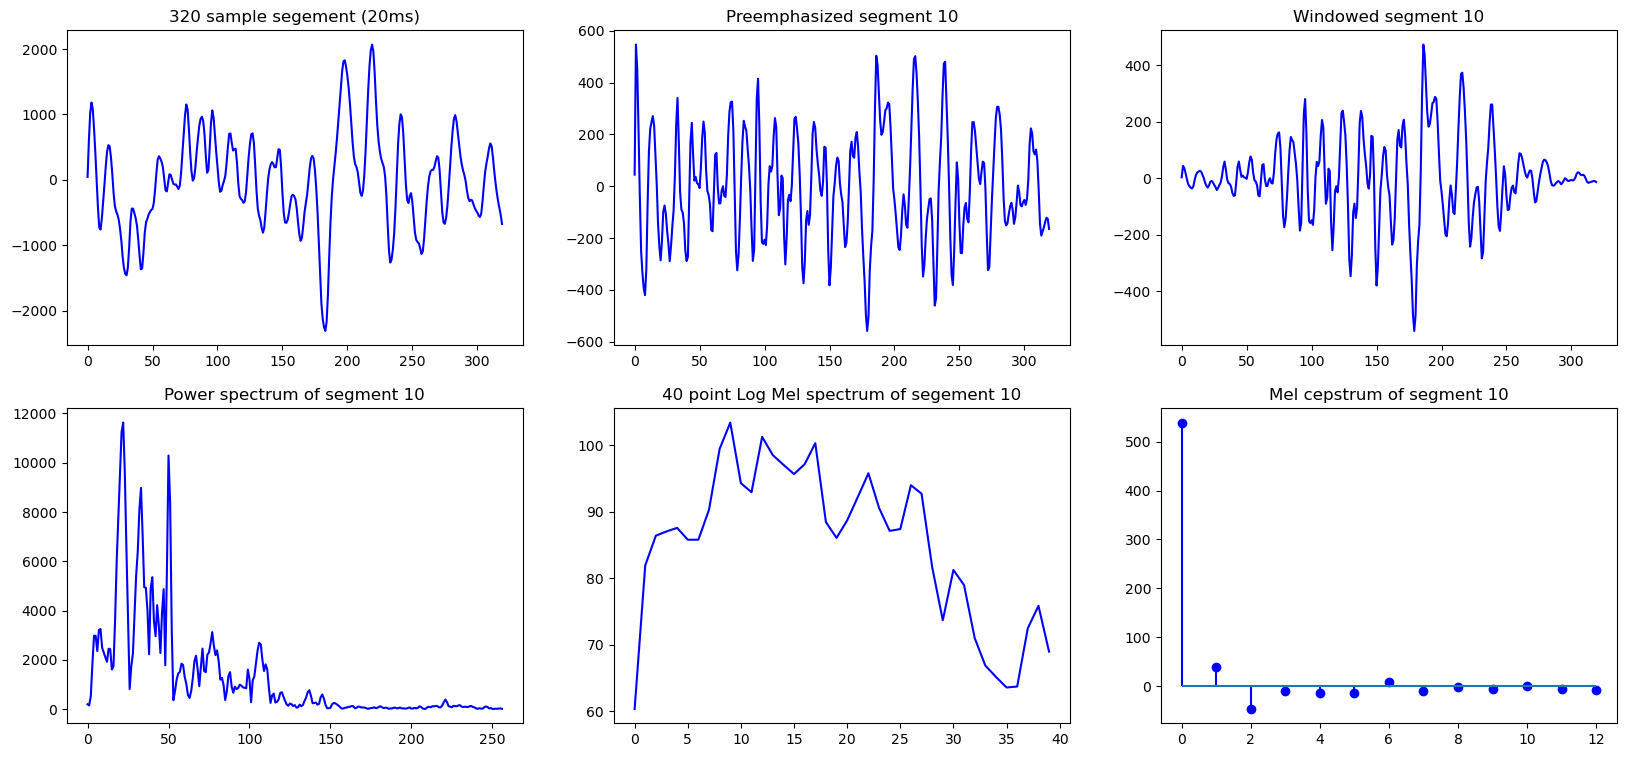

In [78]:
# Plot the amplitude-time line chart for the audio
plt.figure(figsize=(40, 8))
plt.subplot(231)
plt.plot(time*1000, signal/10000, color='blue')
plt.title('Amplitude-Time Line Chart')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (x10^4)')
plt.grid(True)
plt.show()
# Plot segment 10
plt.figure(figsize=(20, 9))
plt.subplot(231)
plt.plot([i for i in range(0,320)], seg[100], color='blue')
plt.title('320 sample segement (20ms)')

# Plot preemphasized segment 10
plt.subplot(232)
plt.plot([i for i in range(0,320)], Preemphasizing(seg[100]), color='blue')
plt.title('Preemphasized segment 10')

# Plot windowed segment 10
plt.subplot(233)
plt.plot([i for i in range(0,320)], windowing(Preemphasizing(seg[100])), color='blue')
plt.title('Windowed segment 10')

# Plot power spectrum of segment 10
plt.subplot(234)
plt.plot([i for i in range(0,257)], FFT(windowing(Preemphasizing(seg[100]))), color='blue')
plt.title('Power spectrum of segment 10')



# Plot 40 point Log Mel spectrum of segement 10
plt.subplot(235)
plt.plot([i for i in range(0,40)], log_mel_spectrum_matrix[100], color='blue')
plt.title('40 point Log Mel spectrum of segement 10')


# plot mel cepstrum of segment 10
plt.subplot(236)
plt.scatter([i for i in range(0, 13)], mel_cepstrum_matrix[100], color='blue')
plt.title('Mel cepstrum of segment 10')

for i, y_value in enumerate(mel_cepstrum_matrix[100]):
    plt.vlines(x=i, ymin=0, ymax=y_value, color='b')
plt.hlines(y=0,xmin=0,xmax=12)
plt.show()